# 损失函数

神经网络的学习通过某个指标表示现在的转态，以这个指标为基础，寻找最优权重参数，神经网络的学习中所用的指标称为损失函数(loss function)。这个损失函数可以是任何函数，但一般使用均方误差和交叉熵误差等。

> 损失函数是表示神经网络性能的“恶劣程度”的指标，即当前的神经网络对监督数据在多大程度上不拟合。

## 均方误差(mean squared error)

均方误差公式如下：
$$
E = \frac 1 2 \sum_k(y_k - t_k)^2
$$
其中$y_k$表示神经网络的输出，$t_k$表示监督数据，$k$表示数据的维度。

In [28]:
import numpy as np

def mean_squared_error(y, t):
    return 0.5 * np.sum((y-t)**2)

t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0] # 正确解为2
y1 = [0.1, 0.05, 0.6, 0, 0.05, 0.1, 0, 0.1, 0, 0] # 2的概率最高
y2 = [0.1, 0.05, 0.1, 0, 0.05, 0.1, 0, 0.6, 0, 0] # 7的概率最高

# 均方误差更小的y1更接近正确解
print(mean_squared_error(np.array(y1), np.array(t))) # 0.09750000000000003

# 均方误差更大的y2更远离正确解
print(mean_squared_error(np.array(y2), np.array(t))) # 0.5975

0.09750000000000003
0.5975


## 交叉熵误差(cross entropy error)

交叉熵误差的公式如下:
$$
E = - \sum_k t_k \log {y_k}
$$

$t_k$是one-hot编码的正解标签。

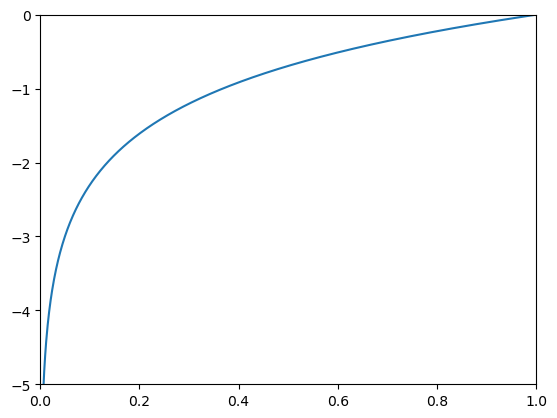

In [29]:
import numpy as np
import matplotlib.pylab as plt

x = np.arange(0.0, 1.0, 0.001)
y = np.log(x + 1e-7)
plt.plot(x, y)
plt.ylim(-5, 0) # 指定y轴的范围
plt.xlim(0.0, 1.0) # 指定x轴的范围
plt.show()

# x越靠近1，y越接近0，交叉熵误差越小

In [30]:
def cross_entropy_error(y, t):
    delta = 1e-7 # 防止log(0)导致无穷大
    return -np.sum(t * np.log(y + delta))

t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0] # 正确解为2
y1 = [0.1, 0.05, 0.6, 0, 0.05, 0.1, 0, 0.1, 0, 0] # 2的概率最高
y2 = [0.1, 0.05, 0.1, 0, 0.05, 0.1, 0, 0.6, 0, 0] # 7的概率最高

# 交叉熵误差更小的y1更接近正确解
print(cross_entropy_error(np.array(y1), np.array(t))) # 0.510825457099338

# 交叉熵误差更大的y2更远离正确解
print(cross_entropy_error(np.array(y2), np.array(t))) # 2.302584092994546

0.510825457099338
2.302584092994546


## mini-batch学习

以交叉熵为例，所有训练数据的损失函数的总和可以写成如下形式:
$$
E = -\frac 1 N \sum_n\sum_k{t_{nk}\log{y_{nk}}}
$$

这里，假设数据有N个，$t_{nk}$表示第n个数据的第k个元素的值($y_{nk}$是神经网络的输出，$t_{nk}$是监督数据)。上式把求单个数据的损失函数的公式扩大到了N份数据，不过最后要除以N进行正规化。通过除以N，可以求单个数据的“平均损失函数”，这样就可以获得和训练数据的数量无关的统一指标。

神经网络的学习是从训练数据中选出一批数据（称为mini-batch），然后对每个mini-batch进行学习。比如，从60000个数据中随机选择100笔，再用这100笔数据进行学习，这种学习方式称为mini-batch学习。也就是说，用随机选择的小批量数据作为全体训练数据的近似值。

In [31]:
import sys, os
sys.path.append(os.pardir) # 为了导入父目录的文件而进行的设定
import numpy as np
from dataset.mnist import load_mnist

print(np.random.choice(60000, 10)) # 从0到59999中随机选择10个数

# 读入数据
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

# 打印各个数据的形状
print(x_train.shape) # (60000, 784)
print(t_train.shape) # (60000, 10)

# 从训练数据中随机选择10笔数据
train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size) # 从0到train_size-1中随机选择batch_size个数
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]

# 交叉熵误差的实现
def cross_entropy_error(y, t):
    if y.ndim == 1: # 如果y是一维数组
        t = t.reshape(1, t.size) # 将正确解t转换为二维数组
        y = y.reshape(1, y.size) # 将预测结果y转换为二维数组

    batch_size = y.shape[0]
    return -np.sum(t * np.log(y + 1e-7)) / batch_size # 交叉熵误差


[19719  6043  7345 36189 39991 33181  8726 44596 58734 31522]
(60000, 784)
(60000, 10)


## 损失函数vs识别精度

以识别精度为指标的缺陷：
1. 参数的导数在绝大多数地方都会变为0
2. 微调参数时，识别精度指标非连续变化（离散、突变）

反之，使用损失函数可以对参数求导，然后以导数为指引，逐步更新参数的值。

# 梯度
全部变量的偏导数汇总而成的向量称为梯度(gradient)，可以如下实现:

[6. 8.]
[0. 4.]
[6. 0.]


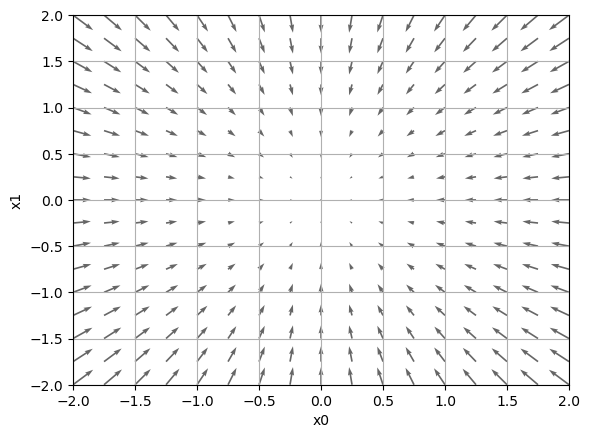

In [32]:
def _numerical_gradient_no_batch(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x) # 生成和x形状相同的数组

    for idx in range(x.size):
        tmp_val = x[idx]

        # f(x+h)的计算
        x[idx] = tmp_val + h
        fxh1 = f(x)

        # f(x-h)的计算
        x[idx] = tmp_val - h
        fxh2 = f(x)

        grad[idx] = (fxh1 - fxh2) / (2*h) # 计算梯度

        x[idx] = tmp_val # 还原值

    return grad

def numerical_gradient(f, X):
    if X.ndim == 1:
        return _numerical_gradient_no_batch(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_no_batch(f, x)
        
        return grad

def function_2(x):
    if x.ndim == 1:
        return np.sum(x**2)
    else:
        return np.sum(x**2, axis=1)

print(numerical_gradient(function_2, np.array([3.0, 4.0]))) # [6. 8.]
print(numerical_gradient(function_2, np.array([0.0, 2.0]))) # [0. 4.]
print(numerical_gradient(function_2, np.array([3.0, 0.0]))) # [6. 0.]

x0 = np.arange(-2, 2.5, 0.25)
x1 = np.arange(-2, 2.5, 0.25)
X, Y = np.meshgrid(x0, x1)

X = X.flatten()
Y = Y.flatten()

grad = numerical_gradient(function_2, np.array([X, Y]).T).T

plt.figure()
plt.quiver(X, Y, -grad[0], -grad[1],  angles="xy",color="#666666")
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.xlabel('x0')
plt.ylabel('x1')
plt.grid()
plt.draw()
plt.show()

以$f(x)=x_0^2+x_1^2$为例，利用梯度学习的过程，可以用如下数学公式表示
$$
\begin{aligned}
x_0&=x_0-\eta \frac {\partial f} {\partial x_0} \\
x_1&=x_1-\eta \frac {\partial f} {\partial x_1} \\
\end{aligned}
$$

$\eta$表示更新量，称为学习率(learning rate)。下面我们用python实现梯度下降法：

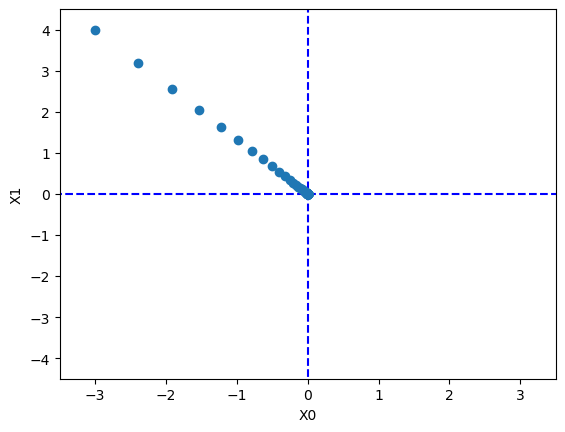

In [33]:
def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x
    x_history = [] # 保存每次更新的值(为了绘图用)

    for i in range(step_num):
        x_history.append( x.copy() )

        grad = numerical_gradient(f, x) # 计算梯度
        x -= lr * grad # 更新参数

    return x, np.array(x_history)

# 求函数f(x0, x1) = x0^2 + x1^2的最小值
def function_2(x):
    return x[0]**2 + x[1]**2

init_x = np.array([-3.0, 4.0]) # 初始值
x, x_history = gradient_descent(function_2, init_x=init_x, lr=0.1, step_num=100)

plt.plot( [-5, 5], [0,0], '--b')
plt.plot( [0,0], [-5, 5], '--b')
plt.plot(x_history[:,0], x_history[:,1], 'o')

plt.xlim(-3.5, 3.5)
plt.ylim(-4.5, 4.5)
plt.xlabel("X0")
plt.ylabel("X1")
plt.show()


神经网络的学习也要求梯度，这里说的梯度是损失函数关于权重参数的梯度。比如有一个2X3的权重W的神经网络，损失函数用L表示，此时，梯度可以用$\frac {\partial L} {\partial W}$表示。

$$
\begin{aligned}
W &= \begin{pmatrix}
w_{11} & w_{12} & w_{13} \\
w_{21} & w_{22} & w_{23}
\end{pmatrix} \\

\frac {\partial L} {\partial W} &= \begin{pmatrix}
\frac {\partial L} {\partial w_{11}} & \frac {\partial L} {\partial w_{12}} & \frac {\partial L} {\partial w_{13}} \\
\frac {\partial L} {\partial w_{21}} & \frac {\partial L} {\partial w_{22}} & \frac {\partial L} {\partial w_{23}}
\end{pmatrix}

\end{aligned}
$$

此时，第一行元素$\frac {\partial L} {\partial w_{11}}$表示当$w_{11}$发生细微变化时，损失函数$L$会发生多大变化。这里重点是，$\frac {\partial L} {\partial W}$的形状和$W$想同。

下面以一个简单的神经网络为例，来实现求梯度的代码。

In [36]:
import sys, os
sys.path.append(os.pardir) # 为了导入父目录的文件而进行的设定
import numpy as np
from common.functions import softmax, cross_entropy_error
from common.gradient import numerical_gradient

# 两层神经网络的类
class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2,3) # 用高斯分布进行初始化

    # 预测
    def predict(self, x):
        return np.dot(x, self.W)

    # 计算损失函数的值
    # x:输入数据，t:监督数据
    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)

        return loss

net = simpleNet()
print(net.W) # 权重参数

x = np.array([0.6, 0.9])
p = net.predict(x)
print(p) # 预测值

print(np.argmax(p)) # 最大值的索引

t = np.array([0, 0, 1]) # 正确解标签
print(net.loss(x, t)) # 损失函数的值

# 求损失函数关于W的梯度
def f(W):
    return net.loss(x, t)

dW = numerical_gradient(f, net.W)
print(dW)

[[ 1.07813763  1.53563281  0.95292919]
 [-0.52130959  0.65481031 -1.52778754]]
[ 0.17770395  1.51070897 -0.80325127]
1
2.6233187347464373
[[ 0.11611295  0.44034936 -0.5564623 ]
 [ 0.17416942  0.66052404 -0.83469345]]


我们发现$\frac {\partial L} {\partial w_{11}}$的值大约是0.2，这表示如果将$w_{11}$增加$h$，那么损失函数的值会增加$0.2h$。再如，$\frac {\partial L} {\partial w_{23}}$的值大约是-0.5，这表示如果将$w_{23}$增加$h$，那么损失函数的值会减小$0.5h$。因此，从减少损失函数值的视角来看，$w_{23}$应该向正向更新，$w_{11}$应该向负向更新。至于更新的程度，$w_{23}$比$w_{11}$的贡献要大。

# 实现学习算法

随机梯度下降法(stochastic gradient descent)，步骤：
1. mini-batch: 从训练数据中随机抽取一部分数据。我们的目标是减少mini-batch的损失函数的值。
2. 计算梯度：求出各个权重参数的梯度。
3. 更新参数：将权重参数沿梯度方向进行微小更新。
4. 重复1/2/3

下面以一个2层神经网络为例。

train acc, test acc | 0.09751666666666667, 0.0974
train acc, test acc | 0.8010333333333334, 0.8052
train acc, test acc | 0.87615, 0.8784
train acc, test acc | 0.8994, 0.9043
train acc, test acc | 0.9081333333333333, 0.9122
train acc, test acc | 0.9151833333333333, 0.9168
train acc, test acc | 0.9206166666666666, 0.9222
train acc, test acc | 0.9245666666666666, 0.9268
train acc, test acc | 0.92755, 0.9294
train acc, test acc | 0.9305833333333333, 0.9323
train acc, test acc | 0.9338666666666666, 0.9359
train acc, test acc | 0.9357833333333333, 0.9359
train acc, test acc | 0.9384666666666667, 0.9399
train acc, test acc | 0.9413666666666667, 0.9414
train acc, test acc | 0.9428833333333333, 0.9427
train acc, test acc | 0.9451, 0.9431
train acc, test acc | 0.9469666666666666, 0.9457


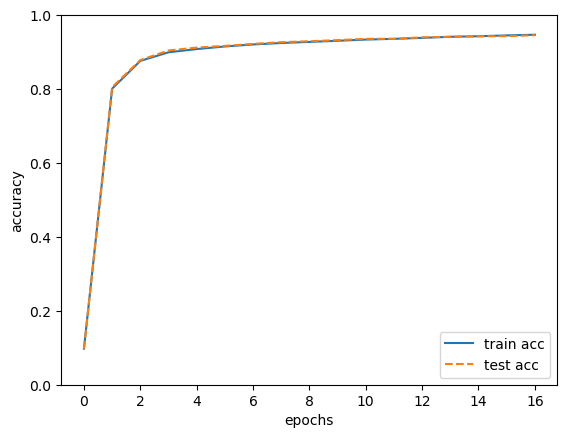

In [38]:
import sys, os
sys.path.append(os.pardir)
from common.functions import *
from common.gradient import numerical_gradient
import numpy as np


class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 初始化权重
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y

    # 计算损失函数的值
    # x:输入数据, t:监督数据
    def loss(self, x, t):
        y = self.predict(x)
        return cross_entropy_error(y, t)

    # 计算识别精度
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    # 计算权重参数的梯度
    # x:输入数据, t:监督数据
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads

    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        dz1 = np.dot(dy, W2.T)
        da1 = sigmoid_grad(a1) * dz1
        grads['W1'] = np.dot(x.T, da1)
        grads['b1'] = np.sum(da1, axis=0)

        return grads

import numpy as np
from dataset.mnist import load_mnist

# 读入数据
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

# 超参数
iters_num = 10000 # 适当设定循环的次数
train_size = x_train.shape[0]
batch_size = 100 # 批数量
learning_rate = 0.1 # 学习率

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1个epoch的重复次数
iter_per_epoch = max(train_size / batch_size, 1)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num):
    # 获取mini-batch
    batch_mask = np.random.choice(train_size, batch_size) # 从0到train_size-1中随机选择batch_size个数
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 通过误差反向传播法求梯度
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch) # 高速版！

    # 更新参数
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    # 记录学习过程
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 计算1个epoch的识别精度
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)

        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()